# Applied Statistics project - Measuring the gravitational acceleration g
### Sagar Clemensen

#### This notebook consists of the data analysis of a project seeking to determine the gravitational acceleration $g$ with the highest achievable precision using two different methods. This was performed as part of the course "NFYK13011U Applied Statistics: From Data to Results".
#### In the first experiment the period of a pendulum with length $L$ is measured:
#### $$T = 2\pi\sqrt{\frac{L}{g}},$$
#### Rearranging the equation $g$ can be determined as:
#### $$g=L\left(\frac{2\pi}{T}\right)^2.$$
#### The second experiment is rolling a ball down an incline. It is assumed that the acceleration is constant. The incline has 5 different points, and the times at which the ball passes them is measured. By measuring the distance between the points and the times at which the ball passes them, $g$ can be determined using the following equation:
#### $$g = \frac{a}{\sin(\theta+\Delta\theta)}\left[1+\frac{2}{5}\frac{D^2}{D^2-d^2}\right],$$
#### where $a$ is the acceleration of the ball, $\theta$ is the angle of the incline with respect to the table, $\Delta\theta$ is the angle of the table with respect to level, $D$ is the diameter of the ball and $d$ is the width of the rail.

In [1]:
# Notebook setup
%load_ext autoreload
%autoreload 2

# Imports
from helpers import *   # your .py file
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit import cost
from scipy import stats
from sympy import * 

In [2]:
# Blinding setup
blinded = False           # Add a random (but fixed) offset to the data
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)
if blinded:
    blinding=r.normal(0, 0.5)
else:
    blinding = 0
print_alg = False

# Pendulum experiment to measure g

## Length of pendulum

In [3]:
tape_measure_m = np.array([22.197, 22.194, 22.195, 22.188])
l_tape_measure, el_tape_measure = compiler(tape_measure_m)
print(f" Tape measure length of pendulum :  {l_tape_measure:.4f} +- {el_tape_measure:.4f} m")

laser_tot_m = np.array([22.152, 22.155, 22.154, 22.155])
laser_mpp_m = np.array([0.062, 0.062, 0.0625, 0.055])
l_laser_tot, el_laser_tot = compiler(laser_tot_m)
l_laser_mpp, el_laser_mpp = compiler(laser_mpp_m)
# print(f" Laser total length of pendulum :  {l_laser_tot:.4f} +- {el_laser_tot:.4f} m")
# print(f" Laser mpp length of pendulum :  {l_laser_mpp:.4f} +- {el_laser_mpp:.4f} m")
l_laser = l_laser_tot - l_laser_mpp
el_laser = np.sqrt(el_laser_tot**2 + el_laser_mpp**2)
print(f" Laser measured length of pendulum :  {l_laser:.4f} +- {el_laser:.4f} m")
length, elength = weighted_mean(np.array([l_tape_measure, l_laser]), np.array([el_tape_measure, el_laser]))
print(f" Weighted mean of pendulum length :  {length:.4f} +- {elength:.4f} m")
chi2_and_prob(np.array([l_tape_measure, l_laser]), length, np.array([el_tape_measure, el_laser]), 1, print_output=True)

 Tape measure length of pendulum :  22.1935 +- 0.0017 m
 Laser measured length of pendulum :  22.0936 +- 0.0017 m
 Weighted mean of pendulum length :  22.1434 +- 0.0012 m
Chi2 value: 1779.51   Ndof = 1    Prob(Chi2,Ndof) = 0.0000


## Period measurements

In [4]:
# File location
filename_A = 'data_pendulum/time_A.dat'
filename_B = 'data_pendulum/time_B.dat'
filename_C = 'data_pendulum/time_C.dat'
filename_D = 'data_pendulum/time_D.dat'

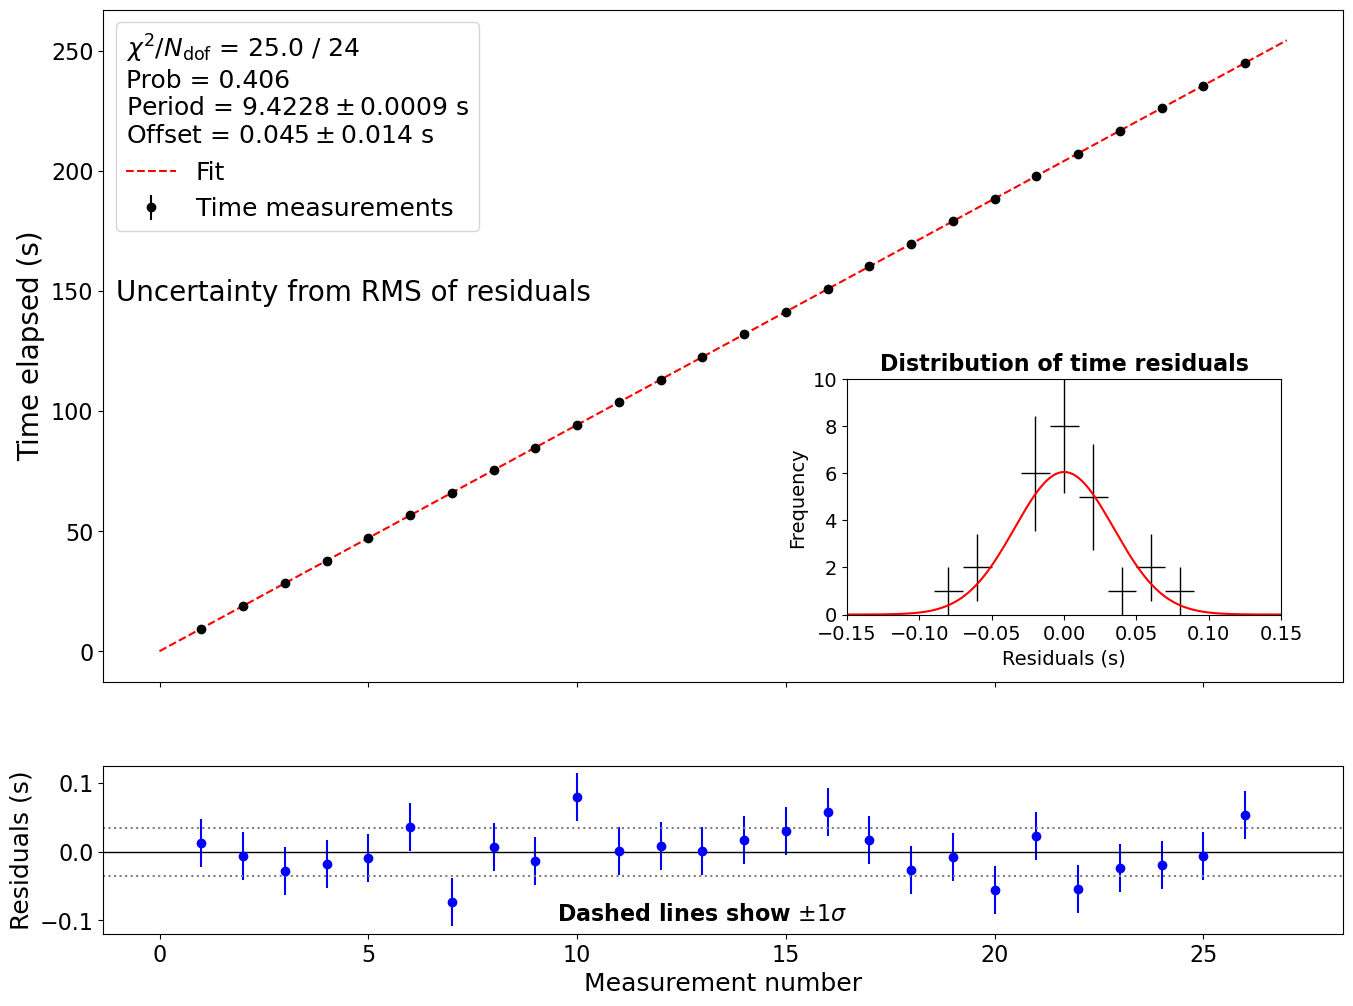

In [5]:
plot_period_fit(filename_D, sig_t=0.1)
plt.show()

## Automated section

In [6]:
filenames = np.array([filename_A, filename_B, filename_C, filename_D])
periods, eperiods, timing_precision = [], [], []
for filename in filenames:
    sig_t = 0.1
    fit_a, efit_a, sig_t_new = period_fit(filename, sig_t, print_output=False, plot=False)
    periods.append(fit_a)
    eperiods.append(efit_a)
    timing_precision.append(sig_t_new)
periods = np.array(periods)
eperiods = np.array(eperiods)
timing_precision = np.array(timing_precision)
print("Individual period measurements and their uncertainties:")
print(np.round(periods, 4))
print(np.round(eperiods, 4))
print(np.round(timing_precision, 3))

Individual period measurements and their uncertainties:
[9.4024 9.3788 9.3486 9.4228]
[0.001  0.0029 0.0048 0.0009]
[0.042 0.112 0.153 0.035]


In [7]:
period = np.average(periods, weights=1/(eperiods**2))
eperiod = np.sqrt(1/np.sum(1/(eperiods**2)))
print(f" Weighted mean of period :  {period:.4f} +- {eperiod:.4f} s")
chi2_and_prob(periods, period, eperiods, n_fixed_params=1, print_output=True)

 Weighted mean of period :  9.4109 +- 0.0007 s
Chi2 value: 524.31   Ndof = 3    Prob(Chi2,Ndof) = 0.0000


## Calculating g from pendulum measurements

In [8]:
# Define variables:
L, T = symbols("L, T")
dL, dT = symbols("sigma_L, sigma_T")

# Define relation, and print:
gP = L*(2*pi/T)**2
if print_alg:
    lprint(latex(Eq(symbols('g_Pen'),gP)))

# Calculate uncertainty and print:
dgP = sqrt((gP.diff(L) * dL)**2 + (gP.diff(T) * dT)**2)
if print_alg:
    lprint(latex(Eq(symbols('sigma_g_Pen'), dgP)))

# Turn expression into numerical functions 
fgP = lambdify((L,T),gP)
fdgP = lambdify((L,dL,T,dT),dgP)


# Define values and their errors
vL, vdL = length, elength
vT, vdT = period, eperiod

# Numerically evaluate expressions and print 
vgP = fgP(vL,vT) + blinding
vdgP = fdgP(vL,vdL,vT,vdT)
lprint(fr'g_P = ({vgP:.4f} \pm {vdgP:.4f})\,\mathrm{{m/s^2}}')

<IPython.core.display.Latex object>

# Ball on an inclined plane to measure g

## Angle
### Using trigonometry to find angle of incline

In [9]:
# Trigonometri
width_m = np.array([0.8945, 0.8950, 0.8980, 0.8965])
height_m = np.array([0.2225, 0.2230, 0.2235, 0.2230])
width, ewidth = compiler(width_m)
height, eheight = compiler(height_m)

# Define variables:
O, A = symbols("O, A")
dO, dA = symbols("sigma_O, sigma_A")

# Define relation, and print:
angle = atan(O/A)
if print_alg:
    lprint(latex(Eq(symbols('theta'),angle)))

# Calculate uncertainty and print:
dangle = sqrt((angle.diff(O) * dO)**2 + (angle.diff(A) * dA)**2)
if print_alg:
    lprint(latex(Eq(symbols('sigma_theta'), dangle)))
# Turn expression into numerical functions 
fangle = lambdify((O,A),angle)
fdangle = lambdify((O,dO,A,dA),dangle)


# Define values and their errors
vO, vdO = height, eheight
vA, vdA = width, ewidth

# Numerically evaluate expressions and print 
vangle = fangle(vO,vA)
vdangle = fdangle(vO,vdO,vA,vdA)
lprint(fr'theta = ({vangle:.4f} \pm {vdangle:.4f})\, rads')
lprint(fr'theta = ({vangle*180/np.pi:.3f} \pm {vdangle*180/np.pi:.3f})\, degrees')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Using goniometer to find angle of incline and $\Delta \theta$

In [10]:
# Goniometer measurements
def process_goniometer(set1, set2):
    data = 90 - np.concatenate((set1, set2))
    return np.mean(data), error(data)

# Normal orientation
gon_norm, egon_norm = process_goniometer(
    np.array([76.40, 76.20, 76.20, 76.10]), 
    np.array([76.00, 76.00, 76.00, 76.00])
    )
print(f"Mean of normal goniometer angle : {gon_norm:.2f} ± {egon_norm:.2f} degrees")

# Reverse orientation
gon_rev, egon_rev = process_goniometer(
    np.array([76.00, 75.90, 76.00, 76.00]), 
    np.array([76.20, 76.10, 76.20, 76.00])
    )
print(f"Mean of reverse goniometer angle : {gon_rev:.2f} ± {egon_rev:.2f} degrees")

# ∆θ calculation
dtheta_gon = (gon_norm - gon_rev) / 2
edtheta_gon = np.sqrt(egon_norm**2 + egon_rev**2) / 2
Math(rf"\Delta \theta_\mathrm{{gon}} = ({dtheta_gon:.2f} \pm {edtheta_gon:.2f})^\circ")

Mean of normal goniometer angle : 13.89 ± 0.05 degrees
Mean of reverse goniometer angle : 13.95 ± 0.04 degrees


<IPython.core.display.Math object>

## Gate positions

In [11]:
gate_m = [
    np.array([0.3115, 0.3125, 0.3110, 0.3115]),
    np.array([0.4610, 0.4620, 0.4605, 0.4615]),
    np.array([0.6125, 0.6135, 0.6125, 0.6130]),
    np.array([0.7630, 0.7635, 0.7625, 0.7645]),
    np.array([0.9151, 0.9060, 0.9050, 0.9060])
    ]

gate_positions = np.array([np.mean(g) for g in gate_m])
egate_positions = np.array([error(g) for g in gate_m])

for x, sx in zip(gate_positions, egate_positions):
    print(f"Gate Position: {x:.4f} ± {sx:.4f} m")


Gate Position: 0.3116 ± 0.0003 m
Gate Position: 0.4613 ± 0.0003 m
Gate Position: 0.6129 ± 0.0002 m
Gate Position: 0.7634 ± 0.0004 m
Gate Position: 0.9080 ± 0.0021 m


## Inner rail width and ball diameter

In [12]:
d_rail_m = np.array([0.00595, 0.00609, 0.00545, 0.00605])
d_rail, ed_rail = compiler(d_rail_m)

diameter_m = [
    np.array([0.00999, 0.01000, 0.00998, 0.00998]),  # small
    np.array([0.01267, 0.01268, 0.01270, 0.01268]),  # medium
    np.array([0.01500, 0.01500, 0.01500, 0.01500])   # large
]
diameters = np.array([np.mean(d) for d in diameter_m])
ediameters = np.array([error(d) for d in diameter_m])

## Gate passing measurements

In [13]:
filenames_small = np.array(['data_BallOnIncline/small1.csv', 'data_BallOnIncline/small2.csv', 'data_BallOnIncline/small3.csv'])
filenames_medium = np.array(['data_BallOnIncline/medium1.csv', 'data_BallOnIncline/medium2.csv', 'data_BallOnIncline/medium3.csv'])
filenames_large = np.array(['data_BallOnIncline/large1.csv', 'data_BallOnIncline/large2.csv', 'data_BallOnIncline/large3.csv'])
rev_filenames_small = np.array(['data_BallOnIncline/rev_small1.csv', 'data_BallOnIncline/rev_small2.csv', 'data_BallOnIncline/rev_small3.csv'])
rev_filenames_medium = np.array(['data_BallOnIncline/rev_medium1.csv', 'data_BallOnIncline/rev_medium2.csv', 'data_BallOnIncline/rev_medium3.csv'])
rev_filenames_large = np.array(['data_BallOnIncline/rev_large1.csv', 'data_BallOnIncline/rev_large2.csv', 'data_BallOnIncline/rev_large3.csv'])
filenames = np.concatenate(([filenames_small, filenames_medium, filenames_large, rev_filenames_small, rev_filenames_medium, rev_filenames_large]))

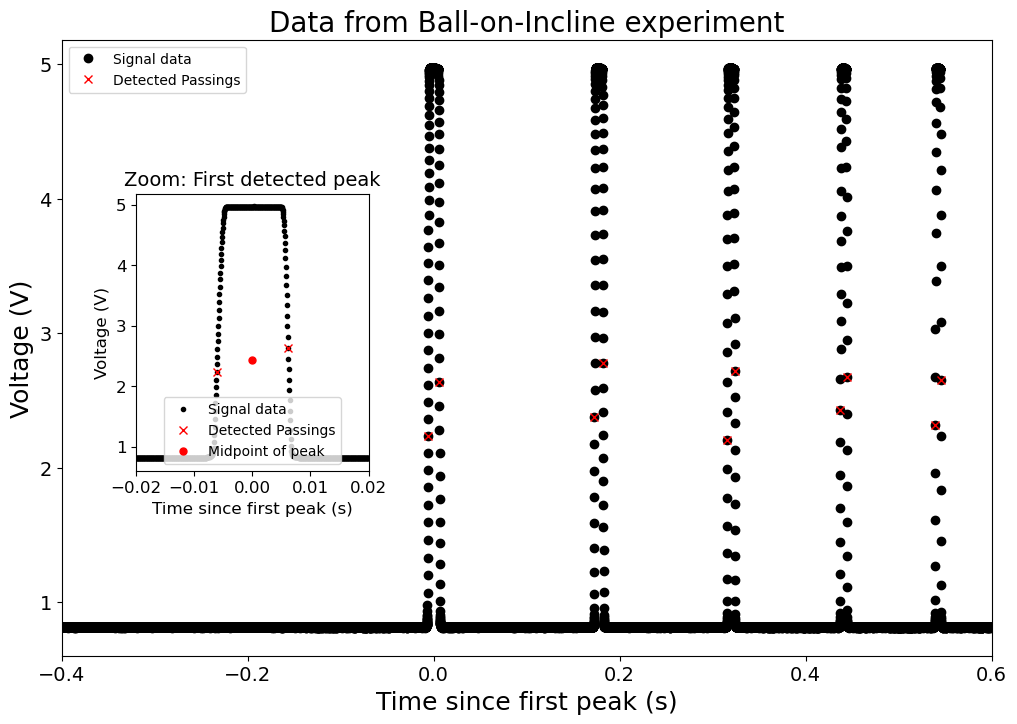

In [14]:
peak_plot(filenames_small[2])

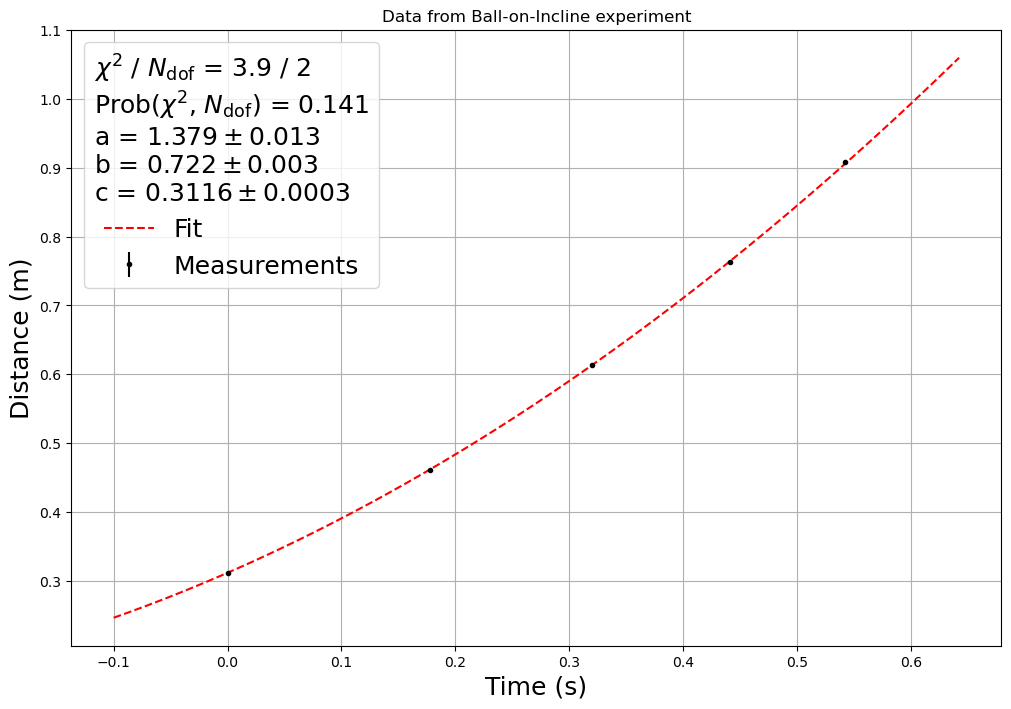

In [15]:
plot_gate_fit(filenames_small[2], gate_positions, egate_positions)

## Automated section

In [16]:
timepass_all = []
for filename in filenames:
    t, V = read_csv(filename)
    tpass = find_midpoints(t, V, tol=20)
    tpass = tpass - tpass[0]
    timepass_all.append(tpass)

fit_a_all = []
e_fit_a_all = []
for i in range(len(timepass_all)):
    fit_a, e_fit_a = fitter(timepass_all[i], gate_positions, egate_positions)
    fit_a_all.append(fit_a)
    e_fit_a_all.append(e_fit_a)

fit_a_all = np.array(fit_a_all)
e_fit_a_all = np.array(e_fit_a_all)

In [17]:
labels = [
    ("small", False),
    ("medium", False),
    ("large", False),
    ("small", True),
    ("medium", True),
    ("large", True),
]
acc_norm = []
eacc_norm = []
acc_rev = []
eacc_rev = []
for i, (size, reversed_dir) in enumerate(labels):
    start = i * 3
    end = start + 3

    a, ea = weighted_mean(fit_a_all[start:end], e_fit_a_all[start:end])
    if reversed_dir:
        acc_rev.append(a)
        eacc_rev.append(ea)
    else:
        acc_norm.append(a)
        eacc_norm.append(ea)
    direction = " in reversed direction" if reversed_dir else ""
    print(f"Weighted mean of acceleration for {size} ball{direction} : "f"{a:.3f} +- {ea:.3f} m/s^2")
acc_norm = np.array(acc_norm)
eacc_norm = np.array(eacc_norm)
acc_rev = np.array(acc_rev)
eacc_rev = np.array(eacc_rev)

Weighted mean of acceleration for small ball : 1.390 +- 0.008 m/s^2
Weighted mean of acceleration for medium ball : 1.511 +- 0.008 m/s^2
Weighted mean of acceleration for large ball : 1.571 +- 0.009 m/s^2
Weighted mean of acceleration for small ball in reversed direction : 1.402 +- 0.008 m/s^2
Weighted mean of acceleration for medium ball in reversed direction : 1.525 +- 0.008 m/s^2
Weighted mean of acceleration for large ball in reversed direction : 1.571 +- 0.009 m/s^2


### Using accelerations to find $\Delta \theta$

In [18]:
# Define variables:
theta, a_rev, a_norm = symbols("theta, a_rev, a_norm")
dtheta, da_rev, da_norm = symbols("sigma_theta, sigma_a_rev, sigma_a_norm")

# Define relation, and print:
d_theta = ((a_norm-a_rev)*sin(theta))/((a_norm+a_rev)*cos(theta))
if print_alg:
    lprint(latex(Eq(symbols('Delta_theta'),d_theta)))

# Calculate uncertainty and print:
dd_theta = sqrt((d_theta.diff(a_norm) * da_norm)**2 + (d_theta.diff(a_rev) * da_rev)**2 + (d_theta.diff(theta) * dtheta)**2)
if print_alg:
    lprint(latex(Eq(symbols('sigma_theta'), dd_theta)))
# Turn expression into numerical functions 
fangle = lambdify((a_norm,a_rev,theta),d_theta)
fdangle = lambdify((a_norm,da_norm,a_rev,da_rev,theta,dtheta),dd_theta)

theta_trig = vangle
etheta_trig = vdangle
deltat_vals = []
edeltat_vals = []
for i in range(3):
    deltat = fangle(acc_norm[i], acc_rev[i], theta_trig)*180/np.pi
    edeltat = fdangle(acc_norm[i], eacc_norm[i], acc_rev[i], eacc_rev[i], theta_trig, etheta_trig)*180/np.pi
    deltat_vals.append(deltat)
    edeltat_vals.append(edeltat)
deltat_vals = np.array(deltat_vals)
edeltat_vals = np.array(edeltat_vals)

In [19]:
print(f" Delta theta for small ball :  ({deltat_vals[0]:.2f} +/- {edeltat_vals[0]:.2f}), degrees")
print(f" Delta theta for medium ball :  ({deltat_vals[1]:.2f} +/- {edeltat_vals[1]:.2f}), degrees")
print(f" Delta theta for large ball :  ({deltat_vals[2]:.2f} +/- {edeltat_vals[2]:.2f}), degrees")
dtheta_acc, edtheta_acc = weighted_mean(deltat_vals, edeltat_vals)
print(f" Weighted mean of Delta theta from accelerations :  {dtheta_acc:.2f} +- {   edtheta_acc:.2f} degrees")
print(f" value of delta theta from goniometer :  {dtheta_gon:.2f} +- {   edtheta_gon:.2f} degrees")
dtheta_val, edtheta_val = weighted_mean(np.array([dtheta_gon, dtheta_acc]), np.array([edtheta_gon, edtheta_acc]))
print(f" Final weighted mean of Delta theta :  {dtheta_val:.2f} +- {edtheta_val:.2f} degrees")
chi2_and_prob(np.array([dtheta_gon, dtheta_acc]), dtheta_val, np.array([edtheta_gon, edtheta_acc]), 1, print_output=True)

 Delta theta for small ball :  (-0.06 +/- 0.05), degrees
 Delta theta for medium ball :  (-0.07 +/- 0.05), degrees
 Delta theta for large ball :  (-0.00 +/- 0.05), degrees
 Weighted mean of Delta theta from accelerations :  -0.04 +- 0.03 degrees
 value of delta theta from goniometer :  -0.03 +- 0.03 degrees
 Final weighted mean of Delta theta :  -0.04 +- 0.02 degrees
Chi2 value: 0.07   Ndof = 1    Prob(Chi2,Ndof) = 0.7902


## Calculating g from ball on incline measurements - goniometer angle (no $\Delta \theta$)

In [20]:
# Define variables:
d, D, theta, a = symbols("d_{rail}, D_{ball}, theta, a")
dd, dD, dtheta, da = symbols("sigma_d, sigma_D, sigma_theta, sigma_a")


# Define relation, and print:
gI = a/sin(theta)*(1+2/5 * D**2/(D**2-d**2))
if print_alg:
    lprint(latex(Eq(symbols('g_Inc'),gI)))

# Calculate uncertainty and print:
dgI = sqrt((gI.diff(a) * da)**2+(gI.diff(theta) * dtheta)**2 + (gI.diff(d) * dd)**2 + (gI.diff(D) * dD)**2)
if print_alg:
    lprint(latex(Eq(symbols('sigma_g_Inc'), dgI)))
# Turn expression into numerical functions 

fgI = lambdify((d, D, theta, a),gI)
fdgI = lambdify((d,dd,D,dD,theta, dtheta, a, da),dgI)

# Define values and their errors
vd, vdd = d_rail, ed_rail
#vD, vdD = d_large, ed_large
vtheta, vdtheta = gon_norm*np.pi/180, egon_norm*np.pi/180

g_vals = []
eg_vals = []

# Numerically evaluate expressions and print 
for i in range(len(diameters)):
    vD, vdD = diameters[i], ediameters[i]
    va, vda = acc_norm[i], eacc_norm[i]
    vgI = fgI(vd, vD, vtheta, va) +  blinding
    vdgI = fdgI(vd, vdd, vD, vdD, vtheta, vdtheta, va, vda)
    g_vals.append(vgI)
    eg_vals.append(vdgI)
    lprint(fr'g_I = ({vgI:.2f} \pm {vdgI:.2f})\,\mathrm{{m/s^2}}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [21]:
g_vals_gon = np.array(g_vals[0:3])
eg_vals_gon = np.array(eg_vals[0:3])
g_boi_gon, eg_boi_gon = weighted_mean(g_vals_gon, eg_vals_gon)
print(f" Weighted mean of g from ball on incline and goniometer angle:  {g_boi_gon:.2f} +- {eg_boi_gon:.2f} m/s^2")
chi2_and_prob(g_vals_gon, g_boi_gon, eg_vals_gon, 1, print_output=True)

 Weighted mean of g from ball on incline and goniometer angle:  9.53 +- 0.04 m/s^2
Chi2 value: 6.44   Ndof = 2    Prob(Chi2,Ndof) = 0.0400


## Calculating g from ball on incline measurements - trigonometric angle (with $\Delta \theta$)

In [22]:
# Define variables:
deltatheta = symbols("Delta_theta")
ddeltatheta = symbols("sigma_Delta_theta")

# Define relation, and print:
gI = a/sin(theta+deltatheta)*(1+2/5 * D**2/(D**2-d**2))
if print_alg:   
    lprint(latex(Eq(symbols('g_Inc'),gI)))

# Calculate uncertainty and print:
dgI = sqrt((gI.diff(a) * da)**2+(gI.diff(theta) * dtheta)**2 + (gI.diff(d) * dd)**2 + (gI.diff(D) * dD)**2 + (gI.diff(deltatheta) * ddeltatheta)**2)
if print_alg:
    lprint(latex(Eq(symbols('sigma_g_Inc'), dgI)))
# Turn expression into numerical functions 

fgI = lambdify((d, D, theta, deltatheta, a), gI)
fdgI = lambdify((d,dd,D,dD,theta, dtheta, deltatheta, ddeltatheta, a, da),dgI)

# Define values and their errors
vd, vdd = d_rail, ed_rail
vtheta, vdtheta = vangle, vdangle
vdeltatheta, vddeltatheta = dtheta_val*np.pi/180, edtheta_val*np.pi/180


# Numerically evaluate expressions and print 
for i in range(len(diameters)):
    vD, vdD = diameters[i], ediameters[i]
    va, vda = acc_norm[i], eacc_norm[i]
    vgI = fgI(vd, vD, vtheta, vdeltatheta, va) +  blinding
    vdgI = fdgI(vd, vdd, vD, vdD, vtheta, vdtheta, vdeltatheta, vddeltatheta, va, vda)
    g_vals.append(vgI)
    eg_vals.append(vdgI)
    lprint(fr'g_I = ({vgI:.2f} \pm {vdgI:.2f})\,\mathrm{{m/s^2}}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [23]:
g_vals_trig = np.array(g_vals[3:6])
eg_vals_trig = np.array(eg_vals[3:6])
g_boi_trig, eg_boi_trig = weighted_mean(g_vals_trig, eg_vals_trig)
print(f" Weighted mean of g from ball on incline and trigonometric angle:  {g_boi_trig:.2f} +- {eg_boi_trig:.2f} m/s^2")
chi2_and_prob(g_vals_trig, g_boi_trig, eg_vals_trig, 1, print_output=True)

 Weighted mean of g from ball on incline and trigonometric angle:  9.50 +- 0.04 m/s^2
Chi2 value: 7.28   Ndof = 2    Prob(Chi2,Ndof) = 0.0263


## Final result from ball on incline experiment

In [24]:
g_boi, eg_boi = weighted_mean(np.array([g_boi_gon, g_boi_trig]), np.array([eg_boi_gon, eg_boi_trig]))
print(f" Final weighted mean of g from ball on incline :  {g_boi:.2f} +- {eg_boi:.2f} m/s^2")
chi2_and_prob(np.array([g_boi_gon, g_boi_trig]), g_boi, np.array([eg_boi_gon, eg_boi_trig]), 1, print_output=True)

 Final weighted mean of g from ball on incline :  9.52 +- 0.03 m/s^2
Chi2 value: 0.26   Ndof = 1    Prob(Chi2,Ndof) = 0.6133
